In [ ]:
!gdown https://drive.google.com/file/d/1rJvDj7e51J171IImZ8q9KpgTILwLJGng/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1rJvDj7e51J171IImZ8q9KpgTILwLJGng
From (redirected): https://drive.google.com/uc?id=1rJvDj7e51J171IImZ8q9KpgTILwLJGng&confirm=t&uuid=abc4464e-0ab7-4bc8-9d49-fd8e447b2080
To: /content/HV-AI-2024.zip
100% 1.14G/1.14G [00:13<00:00, 86.2MB/s]


#How to add the file to gdrive

1. Open the drive link shared
2. Click the three dots next to ***HV-AI-2024*** and select 'Make a copy'

In [ ]:
# !cp /content/drive/MyDrive/HV-AI-2024.zip /content/HV-AI-2024.zip
!unzip HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm /content/HV-AI-2024.zip
!rm -rf /content/sample_data
from google.colab import output
output.clear()

# **Plot Sample Images**

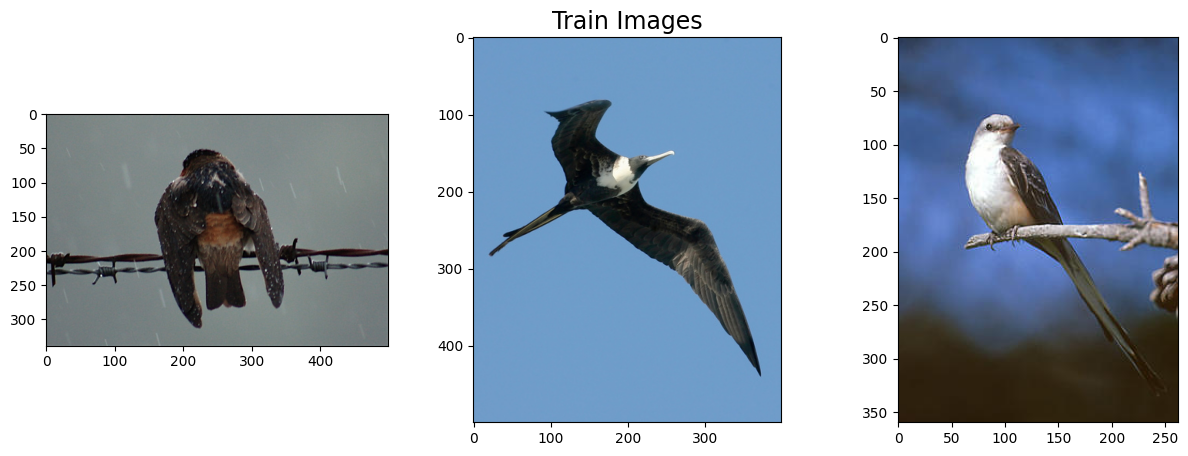

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob


train_images = glob('images/train/*.jpg')[0:3]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

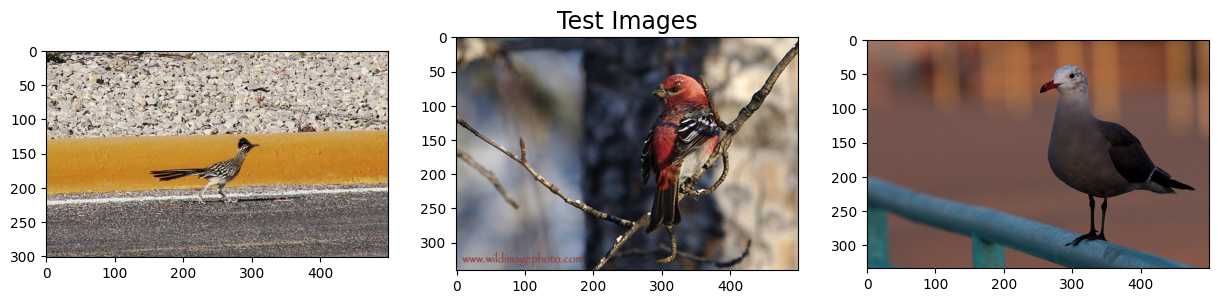

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

# **Load/Preprocess **data****

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.5 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import time
from tqdm import tqdm
import os

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import numpy as np
from torchvision import models

In [ ]:
import os
import shutil

# Directory where your images are located
image_dir = '/content/images/train'
# Directory where class directories will be created
class_base_dir = '/content/train'

# Get the list of image files in the directory
image_files = os.listdir(image_dir)

# Iterate over each image file
for image_file in image_files:
    # Extract class number from the filename (before the underscore)
    class_id = image_file.split('_')[0]

    # Define the directory path for the class under /content/train/
    class_dir = os.path.join(class_base_dir, f'class_{class_id}')

    # If the class directory doesn't exist, create it
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    # Move the image to the corresponding class directory
    source_path = os.path.join(image_dir, image_file)
    destination_path = os.path.join(class_dir, image_file)

    shutil.move(source_path, destination_path)

print("Images have been organized into their respective class directories under /content/train/")

Images have been organized into their respective class directories under /content/train/


In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

classes = get_classes("/content/train/")

def get_data_loaders(data_dir, batch_size, train=False):
    if train:
        # Transformations for training
        transform = transforms.Compose([
            transforms.RandomRotation(degrees=15),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # Load dataset
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        # Split into 80% training and 20% validation
        train_data_len = int(len(all_data) * 0.80)
        val_data_len = len(all_data) - train_data_len
        train_data, val_data = random_split(all_data, [train_data_len, val_data_len])

        # Create dataloaders for training and validation
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data_len

    else:
        # Transformations for validation
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # Load dataset
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        # Split into 80% training and 20% validation
        train_data_len = int(len(all_data) * 0.80)
        val_data_len = len(all_data) - train_data_len
        train_data, val_data = random_split(all_data, [train_data_len, val_data_len])

        # Create dataloaders for validation
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, val_data_len


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset_path = "train/"  # Change this to your dataset path
train_loader, train_data_len = get_data_loaders(dataset_path, batch_size=256, train=True)
val_loader, val_data_len = get_data_loaders(dataset_path, batch_size=64, train=False)


In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": val_data_len
}

In [ ]:
print(len(train_loader))
print(len(val_loader))

print(train_data_len, val_data_len)

19
19
4795 1199


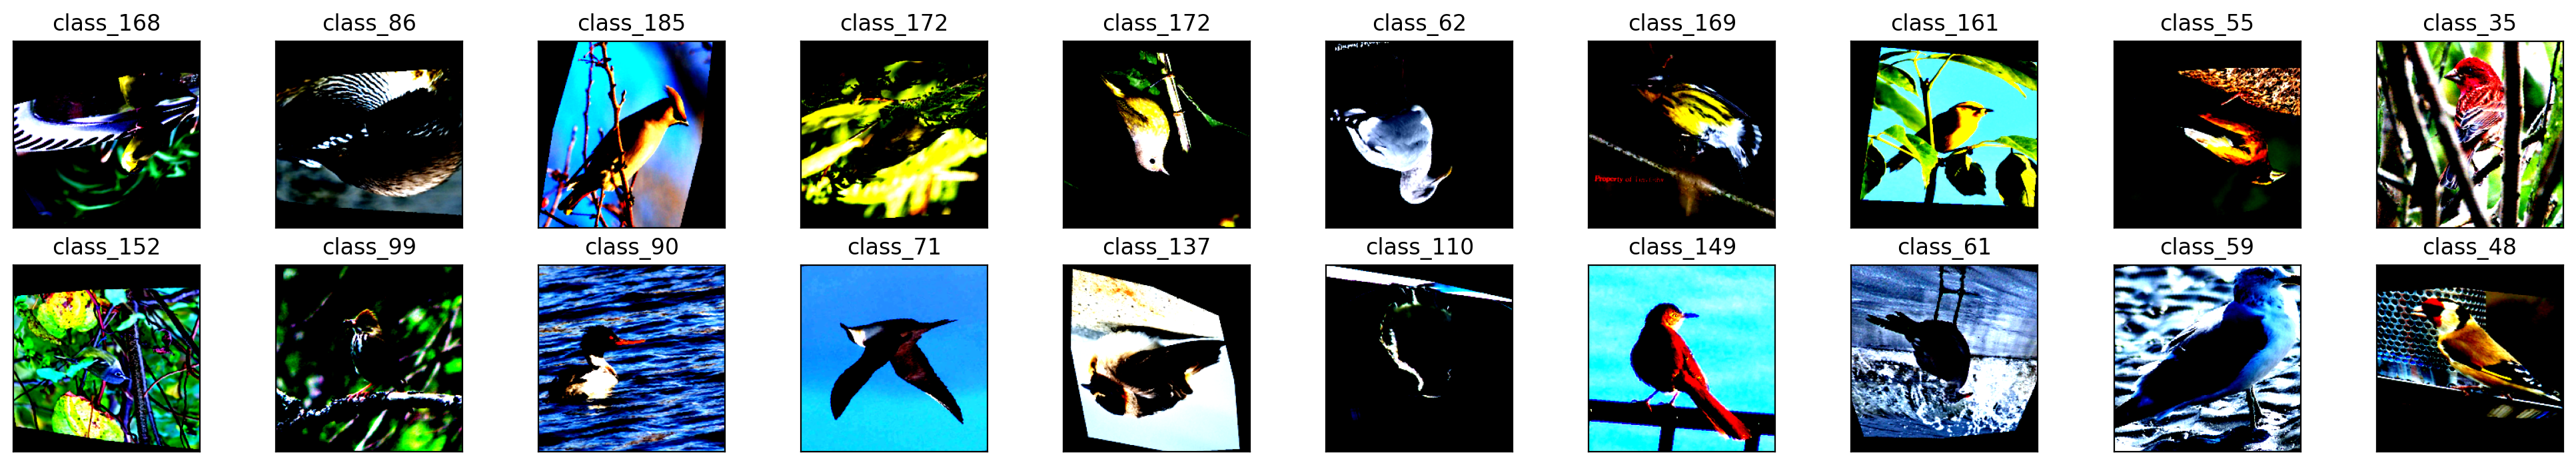

In [ ]:
# Display images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# **Model initialization/Training**

In [ ]:
torch.backends.cudnn.benchmark = True
model = torchvision.models.efficientnet_b2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 2048),  # Increase the size of the first fully connected layer
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))  # Adjust the output size to match the number of classes
)


# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 27.0MB/s]


In [ ]:
print(f"Trainable Params: {count_parameters(model)}")

Trainable Params: 3295432


In [ ]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [ ]:
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.96)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [ ]:
import os

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                training_history['accuracy'].append(torch.tensor(epoch_acc).cpu())  # Convert to tensor and move to CPU
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(torch.tensor(epoch_acc).cpu())  # Convert to tensor and move to CPU
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_{}.pt'.format(epoch))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'training_history': training_history,
            'validation_history': validation_history
        }, checkpoint_path)

        print("Checkpoint saved:", checkpoint_path)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, step_scheduler,
                       num_epochs=20)


Epoch 0/19
----------


100%|██████████| 19/19 [00:59<00:00,  3.14s/it]


train Loss: 5.0082 Acc: 0.1070


100%|██████████| 19/19 [00:08<00:00,  2.37it/s]


val Loss: 4.2731 Acc: 0.3945
Checkpoint saved: checkpoints/checkpoint_epoch_0.pt

Epoch 1/19
----------


100%|██████████| 19/19 [00:54<00:00,  2.86s/it]


train Loss: 3.9477 Acc: 0.3535


100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


val Loss: 3.2865 Acc: 0.5371
Checkpoint saved: checkpoints/checkpoint_epoch_1.pt

Epoch 2/19
----------


100%|██████████| 19/19 [00:47<00:00,  2.48s/it]


train Loss: 3.4141 Acc: 0.4809


100%|██████████| 19/19 [00:07<00:00,  2.51it/s]


val Loss: 2.9681 Acc: 0.6347
Checkpoint saved: checkpoints/checkpoint_epoch_2.pt

Epoch 3/19
----------


100%|██████████| 19/19 [00:54<00:00,  2.85s/it]


train Loss: 3.1574 Acc: 0.5643


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


val Loss: 2.7785 Acc: 0.7098
Checkpoint saved: checkpoints/checkpoint_epoch_3.pt

Epoch 4/19
----------


100%|██████████| 19/19 [00:50<00:00,  2.66s/it]


train Loss: 2.9832 Acc: 0.6221


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


val Loss: 2.6578 Acc: 0.7565
Checkpoint saved: checkpoints/checkpoint_epoch_4.pt

Epoch 5/19
----------


100%|██████████| 19/19 [00:54<00:00,  2.89s/it]


train Loss: 2.8656 Acc: 0.6617


100%|██████████| 19/19 [00:06<00:00,  2.88it/s]


val Loss: 2.5745 Acc: 0.7807
Checkpoint saved: checkpoints/checkpoint_epoch_5.pt

Epoch 6/19
----------


100%|██████████| 19/19 [00:51<00:00,  2.73s/it]


train Loss: 2.7806 Acc: 0.6991


100%|██████████| 19/19 [00:06<00:00,  2.81it/s]


val Loss: 2.5102 Acc: 0.7781
Checkpoint saved: checkpoints/checkpoint_epoch_6.pt

Epoch 7/19
----------


100%|██████████| 19/19 [00:50<00:00,  2.68s/it]


train Loss: 2.7111 Acc: 0.7247


100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


val Loss: 2.4688 Acc: 0.8015
Checkpoint saved: checkpoints/checkpoint_epoch_7.pt

Epoch 8/19
----------


100%|██████████| 19/19 [00:50<00:00,  2.65s/it]


train Loss: 2.6591 Acc: 0.7368


100%|██████████| 19/19 [00:06<00:00,  2.77it/s]


val Loss: 2.4186 Acc: 0.8165
Checkpoint saved: checkpoints/checkpoint_epoch_8.pt

Epoch 9/19
----------


100%|██████████| 19/19 [00:50<00:00,  2.67s/it]


train Loss: 2.6010 Acc: 0.7535


100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


val Loss: 2.3820 Acc: 0.8315
Checkpoint saved: checkpoints/checkpoint_epoch_9.pt

Epoch 10/19
----------


100%|██████████| 19/19 [00:50<00:00,  2.67s/it]


train Loss: 2.5379 Acc: 0.7898


100%|██████████| 19/19 [00:07<00:00,  2.49it/s]


val Loss: 2.3554 Acc: 0.8299
Checkpoint saved: checkpoints/checkpoint_epoch_10.pt

Epoch 11/19
----------


100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


train Loss: 2.5098 Acc: 0.7914


100%|██████████| 19/19 [00:08<00:00,  2.13it/s]


val Loss: 2.3241 Acc: 0.8424
Checkpoint saved: checkpoints/checkpoint_epoch_11.pt

Epoch 12/19
----------


100%|██████████| 19/19 [00:51<00:00,  2.68s/it]


train Loss: 2.4727 Acc: 0.8088


100%|██████████| 19/19 [00:08<00:00,  2.24it/s]


val Loss: 2.2984 Acc: 0.8599
Checkpoint saved: checkpoints/checkpoint_epoch_12.pt

Epoch 13/19
----------


100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


train Loss: 2.4336 Acc: 0.8261


100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


val Loss: 2.2744 Acc: 0.8616
Checkpoint saved: checkpoints/checkpoint_epoch_13.pt

Epoch 14/19
----------


100%|██████████| 19/19 [00:50<00:00,  2.65s/it]


train Loss: 2.4060 Acc: 0.8248


100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


val Loss: 2.2586 Acc: 0.8732
Checkpoint saved: checkpoints/checkpoint_epoch_14.pt

Epoch 15/19
----------


100%|██████████| 19/19 [00:47<00:00,  2.48s/it]


train Loss: 2.3768 Acc: 0.8348


100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


val Loss: 2.2387 Acc: 0.8741
Checkpoint saved: checkpoints/checkpoint_epoch_15.pt

Epoch 16/19
----------


100%|██████████| 19/19 [00:51<00:00,  2.71s/it]


train Loss: 2.3578 Acc: 0.8455


100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


val Loss: 2.2231 Acc: 0.8824
Checkpoint saved: checkpoints/checkpoint_epoch_16.pt

Epoch 17/19
----------


100%|██████████| 19/19 [00:47<00:00,  2.50s/it]


train Loss: 2.3130 Acc: 0.8659


100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


val Loss: 2.2017 Acc: 0.8882
Checkpoint saved: checkpoints/checkpoint_epoch_17.pt

Epoch 18/19
----------


100%|██████████| 19/19 [00:51<00:00,  2.71s/it]


train Loss: 2.3105 Acc: 0.8653


100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


val Loss: 2.1837 Acc: 0.8916
Checkpoint saved: checkpoints/checkpoint_epoch_18.pt

Epoch 19/19
----------


100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


train Loss: 2.2919 Acc: 0.8732


100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


val Loss: 2.1702 Acc: 0.8949
Checkpoint saved: checkpoints/checkpoint_epoch_19.pt

Training complete in 19m 56s
Best val Acc: 0.894912


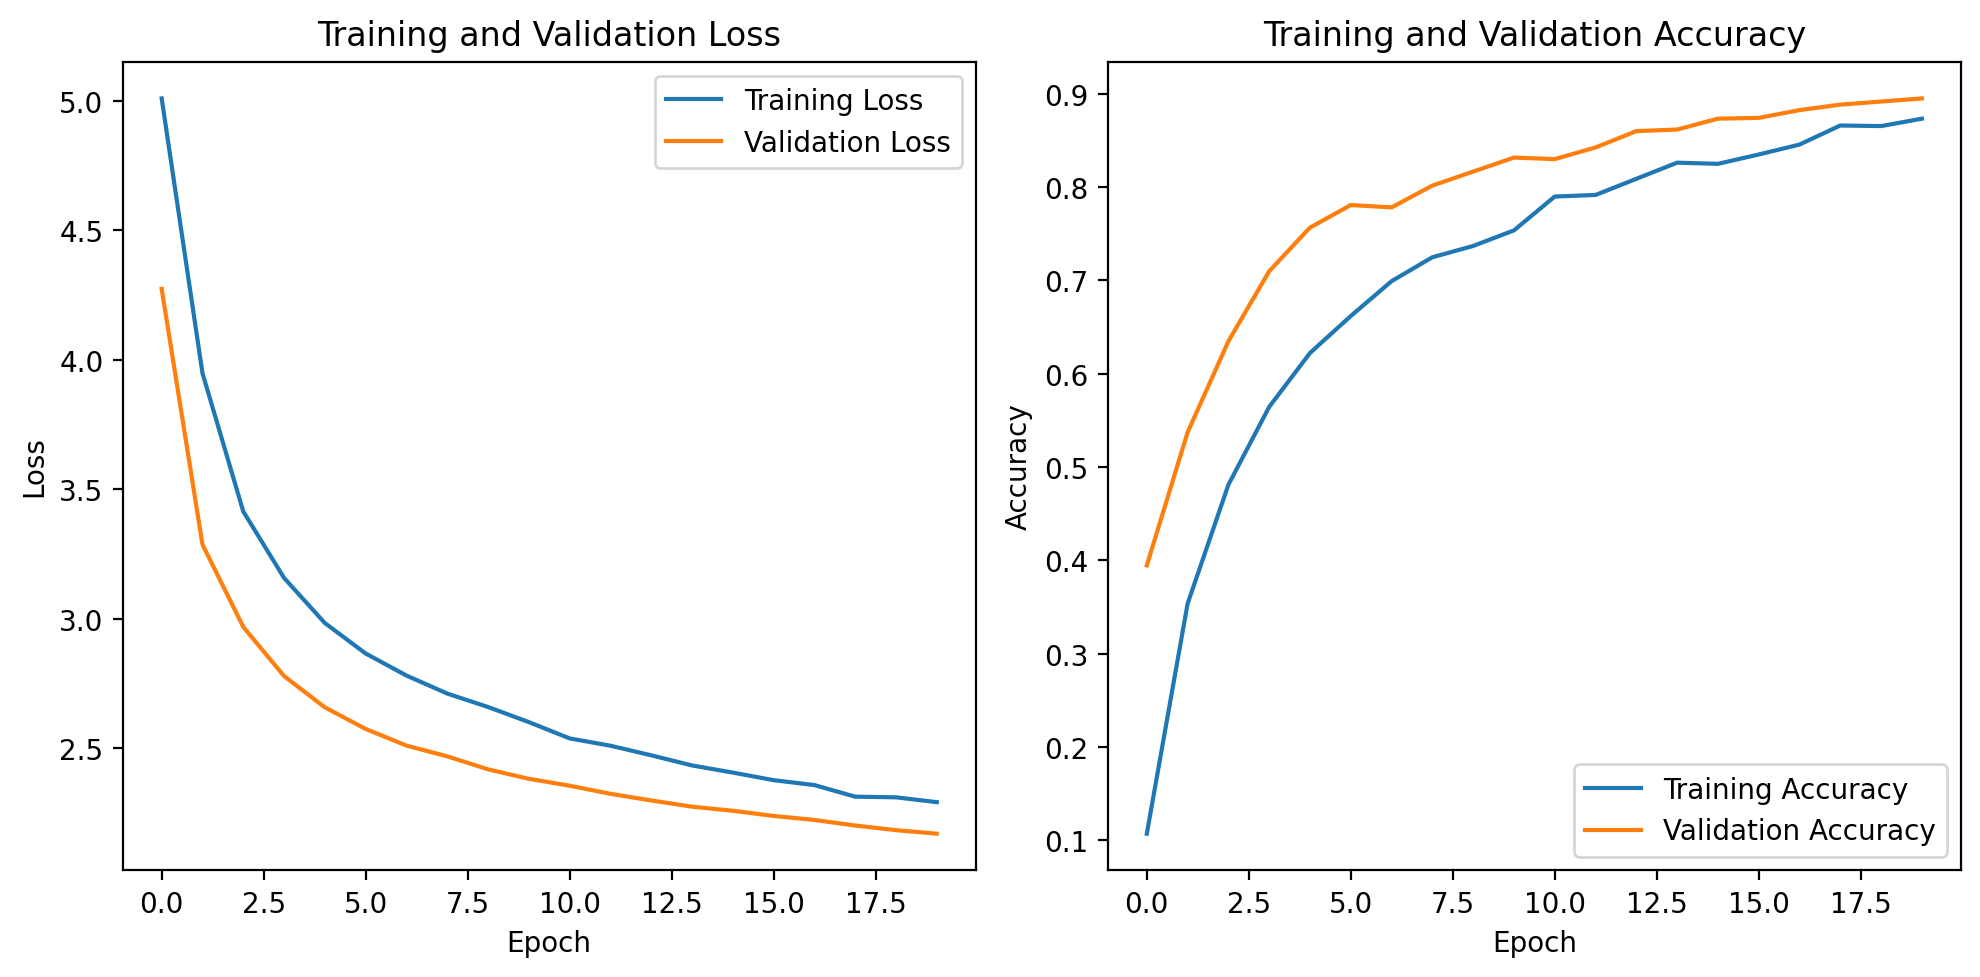

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(training_history, validation_history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_history['loss'], label='Training Loss')
    plt.plot(validation_history['loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.array(training_history['accuracy']), label='Training Accuracy')
    plt.plot(np.array(validation_history['accuracy']), label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(training_history, validation_history)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%%time
val_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model_ft.eval()  # Set model to evaluation mode

for data, target in tqdm(val_loader):  # Use validation loader instead of test_loader
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

    with torch.no_grad():  # Disable gradient calculation
        output = model_ft(data)
        loss = criterion(output, target)  # Calculate the loss
    val_loss += loss.item() * data.size(0)

    _, pred = torch.max(output, 1)  # Get predictions
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    # Loop over each image in the batch to accumulate per-class accuracy
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate average validation loss
val_loss = val_loss / len(val_loader.dataset)
print('Validation Loss: {:.6f}\n'.format(val_loss))

# Calculate per-class accuracy
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Validation Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Validation Accuracy of %5s: N/A (no validation examples)' % (classes[i]))

# Calculate overall accuracy
print('\nValidation Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


100%|██████████| 19/19 [00:06<00:00,  2.89it/s]


Validation Loss: 2.170177

Validation Accuracy of class_1: 100% ( 6/ 6)
Validation Accuracy of class_10: 80% ( 4/ 5)
Validation Accuracy of class_100: 100% ( 7/ 7)
Validation Accuracy of class_101: 100% ( 3/ 3)
Validation Accuracy of class_102: 80% ( 8/10)
Validation Accuracy of class_103: 75% ( 3/ 4)
Validation Accuracy of class_104: 100% ( 6/ 6)
Validation Accuracy of class_105: 75% ( 3/ 4)
Validation Accuracy of class_106: 100% ( 3/ 3)
Validation Accuracy of class_107: 81% ( 9/11)
Validation Accuracy of class_108: 87% ( 7/ 8)
Validation Accuracy of class_109: 100% ( 7/ 7)
Validation Accuracy of class_11: 83% ( 5/ 6)
Validation Accuracy of class_110: 100% ( 4/ 4)
Validation Accuracy of class_111: 100% ( 7/ 7)
Validation Accuracy of class_112: 87% ( 7/ 8)
Validation Accuracy of class_113: 100% ( 4/ 4)
Validation Accuracy of class_114: 88% ( 8/ 9)
Validation Accuracy of class_115: 80% ( 4/ 5)
Validation Accuracy of class_116: 75% ( 6/ 8)
Validation Accuracy of class_117: 83% ( 5/ 6)
Va

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

# **Model Inference**

In [ ]:
import pandas as pd
from PIL import Image
from io import BytesIO
import requests
import torch
from torchvision import transforms
import numpy as np

In [ ]:
# Apply test transforms for inference
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Ensure the model is in evaluation mode
model.eval()

# Set device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load test.csv
test_csv_path = '/content/test.csv'
test_df = pd.read_csv(test_csv_path)

# Path to test images
test_images_dir = '/content/images/test'

# Access the original dataset from the dataloader
original_dataset = dataloaders['train'].dataset
while isinstance(original_dataset, torch.utils.data.Subset):
    original_dataset = original_dataset.dataset

# Verify that original_dataset has 'class_to_idx'
if hasattr(original_dataset, 'class_to_idx'):
    # Get class_to_idx mapping
    class_to_idx = original_dataset.class_to_idx

    # Extract numeric part from 'class_xxx' and create the mapping
    def alphanum_key(s):
        import re
        return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

    # Modify class_to_idx by extracting only the numeric part from the folder names
    class_to_idx = {int(k.split('_')[1]): v for k, v in class_to_idx.items()}

    # Ensure the mapping is sorted by class numbers
    class_to_idx = dict(sorted(class_to_idx.items(), key=lambda x: alphanum_key(f'class_{x[0]}')))

    # Create idx_to_class mapping
    idx_to_class = {v: str(k) for k, v in class_to_idx.items()}

    # Print mappings for debugging
    print("class_to_idx:", class_to_idx)
    print("idx_to_class:", idx_to_class)
else:
    print("Error: 'class_to_idx' not found in the original dataset.")
    # Handle the error or define class_to_idx manually
    # For example, if your classes are '1' to '200':
    classes = [str(i) for i in range(1, 201)]
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    print("Manually defined class_to_idx and idx_to_class.")

# Prepare to collect predictions
predictions = []

# Loop over each image in test.csv
for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    image_path = row['path']  # Assuming 'path' column in test.csv
    full_image_path = os.path.join('/content/', image_path)

    # Load image
    image = Image.open(full_image_path).convert('RGB')

    # Apply test transforms
    input_tensor = apply_test_transforms(image)

    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)  # Shape: [1, C, H, W]
    input_tensor = input_tensor.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)
        # Get the predicted class index and confidence score
        confidence_score, predicted_idx = torch.max(probabilities, dim=1)

        confidence_score = confidence_score.item()
        predicted_idx = predicted_idx.item()

        # Map index back to class label (numeric string from '1' to '200')
        predicted_class = idx_to_class[predicted_idx]  # This will be a string from '1' to '200'

        # Convert predicted_class (string) to integer label (0 to 199)
        predicted_label = int(predicted_class) - 1  # Subtract 1 to shift from 1-200 to 0-199

        # Collect prediction
        predictions.append({
            'path': image_path,
            'predicted_label': predicted_label,
            'confidence_score': confidence_score
        })

# Create dataframe and save to predictions.csv
predictions_df = pd.DataFrame(predictions)
predictions_csv_path = '/content/predictions.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print("Predictions saved to:", predictions_csv_path)


class_to_idx: {1: 0, 2: 111, 3: 123, 4: 134, 5: 145, 6: 156, 7: 167, 8: 178, 9: 189, 10: 1, 11: 12, 12: 23, 13: 34, 14: 45, 15: 56, 16: 67, 17: 78, 18: 89, 19: 100, 20: 112, 21: 114, 22: 115, 23: 116, 24: 117, 25: 118, 26: 119, 27: 120, 28: 121, 29: 122, 30: 124, 31: 125, 32: 126, 33: 127, 34: 128, 35: 129, 36: 130, 37: 131, 38: 132, 39: 133, 40: 135, 41: 136, 42: 137, 43: 138, 44: 139, 45: 140, 46: 141, 47: 142, 48: 143, 49: 144, 50: 146, 51: 147, 52: 148, 53: 149, 54: 150, 55: 151, 56: 152, 57: 153, 58: 154, 59: 155, 60: 157, 61: 158, 62: 159, 63: 160, 64: 161, 65: 162, 66: 163, 67: 164, 68: 165, 69: 166, 70: 168, 71: 169, 72: 170, 73: 171, 74: 172, 75: 173, 76: 174, 77: 175, 78: 176, 79: 177, 80: 179, 81: 180, 82: 181, 83: 182, 84: 183, 85: 184, 86: 185, 87: 186, 88: 187, 89: 188, 90: 190, 91: 191, 92: 192, 93: 193, 94: 194, 95: 195, 96: 196, 97: 197, 98: 198, 99: 199, 100: 2, 101: 3, 102: 4, 103: 5, 104: 6, 105: 7, 106: 8, 107: 9, 108: 10, 109: 11, 110: 13, 111: 14, 112: 15, 113: 1

100%|██████████| 5794/5794 [02:06<00:00, 45.89it/s]


Predictions saved to: /content/predictions.csv


In [ ]:
predictions_df.head()

,path,predicted_label,confidence_score
0,images/test/test_81.jpg,55,0.277817
1,images/test/test_1592.jpg,20,0.820197
2,images/test/test_565.jpg,70,0.198051
3,images/test/test_2078.jpg,63,0.298642
4,images/test/test_3645.jpg,84,0.968996


# **Helper Functions**

In [ ]:
import requests

def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name}
    response = requests.post(url, files=files, data=data)
    return response.json()



# ***Test Inference***


This function is used to save the csv file and send it to the evaluation server.

Format of CSV file (Follow the header names strictly):

        path (str)              predicted_label(int)   confidence_score(float)
    images/test/xx.jpg                  1                         0.6
    images/test/yy.jpg                  2                         0.9
            :                           :                          :
            :                           :                          :

Once the prediction file is saved as shown in the above format, you can send it to the evaluation server along with your email.

Caution: check your **email** before executing the cell.


In [ ]:
print('Accuracy: ')
print(send_results_for_evaluation('test', 'predictions.csv', 'test@gmail.com'))

Accuracy: 
{'overall_accuracy (%)': 55.12599, 'max_accuracy_class': 69, 'max_accuracy (%)': 96.66667, 'min_accuracy_class': 172, 'min_accuracy (%)': 10.0}
